# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('../raw_data/retail_train.csv')
item_features = pd.read_csv('../raw_data/product.csv')
user_features = pd.read_csv('../raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]


data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

In [5]:
recommender.get_als_recommendations(296, N=5)

[1029743, 1106523, 5569230, 916122, 844179]

In [6]:
recommender.get_own_recommendations(296, N=5)

[1029743, 1106523, 5569230, 916122, 844179]

In [7]:
recommender.get_similar_items_recommendation(296, N=5)

[1029743, 1106523, 5569230, 916122, 844179]

In [8]:
recommender.get_similar_users_recommendation(296, N=5)

296


[1029743, 1106523, 5569230, 916122, 844179]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


##### Задание А)

In [9]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [10]:
result_lvl_1['als_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))

In [11]:
result_lvl_1['own_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [12]:
result_lvl_1['sim_item_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))

In [13]:
result_lvl_1['sim_user_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

1
2
4
6
7
8
9
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
39
40
41
42
43
44
46
47
49
51
52
53
55
56
57
58
59
62
63
64
65
66
67
68
69
70
71
72
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
91
92
94
95
97
98
99
100
101
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
121
122
123
124
125
126
127
128
129
131
132
133
134
135
136
137
138
139
140
142
143
144
145
146
147
148
149
150
151
152
153
155
156
157
158
159
160
161
162
164
165
166
167
169
170
171
172
175
176
177
178
180
182
183
184
185
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
207
208
209
210
211
212
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
232
233
235
236
238
239
241
242
243
244
245
246
247
248
249
250
251
253
254
255
256
257
258
259
260
262
263
264
265
266
267
268
269
270
271
273
274
275
276
277
278
279
280
281
282
283
285
286
287
288
289
290
291
292
293
294
296
297
300
301
302
303
304
305
306
307
308
309
311
312
314
315
316
3

2123
2124
2125
2126
2127
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2146
2147
2148
2149
2151
2152
2153
2154
2156
2157
2158
2159
2160
2161
2162
2163
2165
2168
2169
2170
2171
2172
2173
2174
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2202
2203
2204
2205
2206
2207
2208
2209
2211
2213
2214
2215
2216
2217
2218
2221
2222
2223
2224
2225
2226
2227
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2247
2248
2250
2251
2252
2253
2256
2257
2258
2260
2261
2262
2263
2264
2266
2267
2269
2270
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2305
2307
2309
2310
2311
2312
2313
2314
2317
2318
2319
2320
2321
2322
2323
2324
2326
2327
2328
2330
2331
2332
2333
2334
2335
2336
2337
2338
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2351
2352
2353
2354


In [14]:
result_lvl_1.head(2)

,user_id,actual,als_rec,own_rec,sim_item_rec,sim_user_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1135195, 885290, 5577022, 841584, 9803545, 85...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[824758, 1007512, 9297615, 5577022, 9803545, 9...","[835351, 940770, 6552318, 1042571, 841584, 103..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[5569230, 916122, 1029743, 866211, 919534, 104...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[1137346, 1044078, 5569845, 897954, 819978, 88...","[9419422, 1054402, 879373, 1018339, 9487534, 7..."


Посчитаем recall@50

In [15]:
# Рекомендации ALS
result_lvl_1.apply(lambda row: recall_at_k(row['als_rec'], row['actual'], k=50), axis=1).mean()

0.04824075480886327

In [16]:
# Собственные рекомендации
result_lvl_1.apply(lambda row: recall_at_k(row['own_rec'], row['actual'], k=50), axis=1).mean()

0.06524679137206593

In [17]:
# Рекомендации топ похожих товаров
result_lvl_1.apply(lambda row: recall_at_k(row['sim_item_rec'], row['actual'], k=50), axis=1).mean()

0.03812984934046094

In [18]:
# Рекомендации похожих юзеров
result_lvl_1.apply(lambda row: recall_at_k(row['sim_user_rec'], row['actual'], k=50), axis=1).mean()

0.02138200457720217

Лучших кандидатов отбирает алгоритм собственных рекомендаций + топ популярных

##### Задание В)

In [19]:
def best_k(k, recommendations_type, result):
    """Выбирает лучшее количество кандидатов k
    ------
    Input:
    k: list
    recommendations_type: ALS, own, similar item, similar user
    """
    recall = []
    for i in k:
        result[f'best_{i}_rec'] = result['user_id'].apply(lambda x: recommendations_type(x, N=i))
        recall.append(result.apply(lambda row: recall_at_k(row[f'best_{i}_rec'], row['actual'], k=i), axis=1).mean())
    return recall

In [20]:
k = [20, 50, 100, 200, 300, 400, 500, 600]
recall = best_k(k, recommender.get_own_recommendations, result_lvl_1)

Text(0, 0.5, 'Recall')

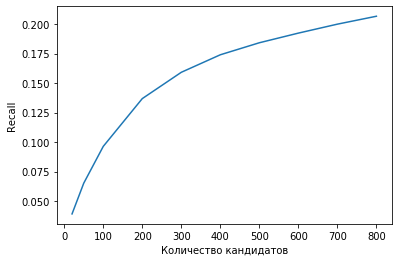

In [21]:
plt.plot(k, recall)
plt.xlabel('Количество кандидатов')
plt.ylabel('Recall')

При росте k растет и recall

##### Задание С)

Число k надо выбирать так, что бы модель второго уровня могла справиться с количество данных. В данном случае, я бы остановил выбор на 400 кандидатах.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [22]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [23]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [24]:
# Разворачиваем списки кандидатов для каждого юзера в столбец
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)

users_lvl_2.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


In [25]:
# Формируем датасет с целевой переменной
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)

In [26]:
targets_lvl_2.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


In [27]:
# Удаляем появившиеся дубликаты
targets_lvl_2 = targets_lvl_2.drop_duplicates(keep='first')

In [28]:
# Добавляем фичи юзеров и товаров
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


Добавим фичи юзеров

In [29]:
# Средний чек
mean_check = data_train_lvl_2.groupby(['user_id', 'basket_id'])['sales_value'].sum().reset_index()
mean_check = mean_check.groupby('user_id')['sales_value'].mean().reset_index()
mean_check.rename(columns={'sales_value': 'mean_check'}, inplace=True)
mean_check.head(3)

,user_id,mean_check
0,1,48.825714
1,2,47.572500
2,4,39.796667


In [30]:
# Кол-во покупок в каждой категории
num_purchases_in_category = data_train_lvl_2.merge(item_features, on='item_id', how='left')
num_purchases_in_category.loc[num_purchases_in_category['department'] == ' ', 'department'] = 'UNKNOWN'
num_purchases_in_category = num_purchases_in_category.groupby(['user_id', 'department'])['quantity'].count().reset_index()
num_purchases_in_category.rename(columns={'quantity': 'num_purchases_in_category'}, inplace=True)
num_purchases_in_category.head(3)

,user_id,department,num_purchases_in_category
0,1,DELI,4
1,1,DRUG GM,13
2,1,GROCERY,93


In [31]:
targets_lvl_2 = targets_lvl_2.merge(mean_check, on='user_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(num_purchases_in_category, on=['user_id', 'department'], how='left')

In [32]:
targets_lvl_2.head(10)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,num_purchases_in_category
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,3.0
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,139.0
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,29.0
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,29.0
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,29.0
5,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,8.0
6,2070,1032703,0.0,1087,SEAFOOD-PCKGD,National,SEAFOOD - FROZEN,FRZN BRD STICK/PORTON,10.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,1.0
7,2070,1138596,0.0,111,DRUG GM,National,CIGARETTES,CIGARETTES,523670 CTN,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,29.0
8,2070,10198378,0.0,69,GROCERY,Private,DOG FOODS,DRY DOG VALUE (PET PRIDE/KLR/G,50 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,139.0
9,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,8.0


Добавим фичи товаров

In [33]:
# Количество покупок в неделю
num_purchases_in_week = data_train_lvl_2.groupby(['item_id', 'week_no'])['quantity'].sum().reset_index()
num_purchases_in_week = num_purchases_in_week.groupby('item_id')['quantity'].mean().reset_index()
num_purchases_in_week.rename(columns={'quantity': 'num_purchases_in_week'}, inplace=True)
num_purchases_in_week.head(2)

,item_id,num_purchases_in_week
0,28116,1.0
1,28117,1.0


In [34]:
# Цена
price = data_train_lvl_2.groupby('item_id')['sales_value'].sum() / data_train_lvl_1.groupby('item_id')['quantity'].sum()
price = price.groupby('item_id').mean().reset_index()
price.columns = ['item_id', 'price']
price['price'].fillna(0, inplace= True)
price.head(2)

,item_id,price
0,28116,0.0
1,28117,0.0


In [35]:
targets_lvl_2 = targets_lvl_2.merge(num_purchases_in_week, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(price, on='item_id', how='left')

Добавим фичи пары юзер-товар

In [36]:
# (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
mean_price_in_category = data_train_lvl_2.merge(item_features, on='item_id', how='left')
mean_price_in_category.loc[mean_price_in_category['department'] == ' ', 'department'] = 'UNKNOWN'

department_quantity = mean_price_in_category.groupby('department')['quantity'].sum().reset_index()
mean_price_in_category = mean_price_in_category.groupby('department')['sales_value'].sum().reset_index()
mean_price_in_category['mean_price'] = mean_price_in_category['sales_value'] / department_quantity['quantity']
mean_price_in_category.drop(['sales_value'], axis=1, inplace=True)
mean_price_in_category.head(3)

,department,mean_price
0,AUTOMOTIVE,5.390000
1,CHEF SHOPPE,2.632464
2,CNTRL/STORE SUP,1.000000


In [37]:
targets_lvl_2 = targets_lvl_2.merge(mean_price_in_category, on='department', how='left')
targets_lvl_2['dif_price'] = targets_lvl_2['mean_price'] - targets_lvl_2['price']
targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,num_purchases_in_category,num_purchases_in_week,price,mean_price,dif_price
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,3.0,1.666667,0.191827,4.211823,4.019996
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,139.0,1.000000,0.207358,1.893912,1.686553
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,29.0,NaN,0.000000,3.097031,3.097031


In [38]:
targets_lvl_2.fillna(0, inplace= True)
targets_lvl_2.head(10)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,num_purchases_in_category,num_purchases_in_week,price,mean_price,dif_price
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,3.0,1.666667,0.191827,4.211823,4.019996
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,139.0,1.000000,0.207358,1.893912,1.686553
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,29.0,0.000000,0.000000,3.097031,3.097031
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,29.0,0.000000,0.000000,3.097031,3.097031
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,29.0,2.200000,1.831042,3.097031,1.265989
5,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,8.0,2.000000,0.240435,2.930810,2.690375
6,2070,1032703,0.0,1087,SEAFOOD-PCKGD,National,SEAFOOD - FROZEN,FRZN BRD STICK/PORTON,10.5 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,1.0,2.000000,0.380260,4.678647,4.298387
7,2070,1138596,0.0,111,DRUG GM,National,CIGARETTES,CIGARETTES,523670 CTN,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,29.0,0.000000,0.000000,3.097031,3.097031
8,2070,10198378,0.0,69,GROCERY,Private,DOG FOODS,DRY DOG VALUE (PET PRIDE/KLR/G,50 LB,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,139.0,2.166667,0.901875,1.893912,0.992037
9,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,8.0,7.200000,0.465528,2.930810,2.465283


In [39]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [40]:
cat_feats = X_train.columns[2:15].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [41]:
# Тренируем модель и предсказываем вероятности
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

C:\Users\Spoukster\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Spoukster\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Spoukster\anaconda3\lib\site-packages\lightgbm\basic.py:863: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


In [42]:
# Берем вероятность класса 1
proba_1 = [i[1] for i in train_preds]

In [43]:
result = targets_lvl_2[['user_id', 'item_id']]
result['proba'] = proba_1
result.head(2)

C:\Users\Spoukster\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,item_id,proba
0,2070,1105426,0.030645
1,2070,1097350,0.022532


In [44]:
# Упорядочим по юзерам и вероятности
result.sort_values(['user_id', 'proba'], ascending=False, inplace=True)
result = result.groupby('user_id').head(5)
result.head(10)

C:\Users\Spoukster\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,item_id,proba
68652,2500,1086061,0.205657
68655,2500,5572308,0.169843
68666,2500,9677874,0.165108
68654,2500,1065538,0.161604
68695,2500,890909,0.161366
86121,2499,9523059,0.181246
86104,2499,889989,0.162776
86111,2499,1138858,0.156271
86131,2499,867931,0.151139
86133,2499,9575582,0.140778


In [45]:
# Соберем результаты в строку
result = result.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'lgbm_rec']
result.head(3)

,user_id,lgbm_rec
0,1,"[1124029, 877391, 9655212, 856942, 983897]"
1,2,"[898847, 862725, 1110244, 907099, 9416729]"
2,4,"[908283, 883932, 1079528, 955867, 1052294]"


In [46]:
# Уберем юзеров, которых нет во втором тренировочном наборе
train_users_lvl_2 = result['user_id'].unique()
data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2['user_id'].isin(train_users_lvl_2)]
data_val_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.0,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.3,112,92,0.0,0.0


In [47]:
# Создадим валидационный набор
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


In [48]:
result_lvl_2 = result_lvl_2.merge(result, on='user_id', how='left')
result_lvl_2.head(2)

,user_id,actual,lgbm_rec
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1124029, 877391, 9655212, 856942, 983897]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[900802, 1098844, 12757544, 6979393, 825541]"


Посмотрим на качество рекомендаций 2хуровневой модели по метрике precision@5.

In [49]:
result_lvl_2.apply(lambda row: precision_at_k(row['lgbm_rec'], row['actual'], k=5), axis=1).mean()

0.159895561357701

Для сравнения посмотрим на precision@5 лучшего метода отбора кандидатов одноуровневой модели own_recommended и ALS

In [50]:
result_lvl_1.apply(lambda row: precision_at_k(row['own_rec'], row['actual'], k=50), axis=1).mean()

0.07224698235840335

In [51]:
result_lvl_1.apply(lambda row: precision_at_k(row['als_rec'], row['actual'], k=50), axis=1).mean()

0.055886722376973244

Видим, что двухуровневая модель показывает лучший результат. Но это без подбора гиперпараметров.

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 